In [186]:
Needs["Screws`", "./Screws.m"];
Needs["RobotLinks`", "./RobotLinks.m"];

In [209]:
(* base pose of link i frame in the snake head frame (all joint angles = 0) *)
gsi0[i_] := TwistExp[{0, l(i - 1), 0, 0, 0, 0}, 1];

(* twist coordinates for joint i *)
ξ[i_] := Piecewise[{{{0, 0, -l(i - 1/2), 1, 0, 0}, EvenQ[i]},
              {{l(i - 1/2), 0, 0, 0, 0, 1}, OddQ[i]}}];

n = 8;
ids = Range[n];
gsi0s = Map[gsi0, ids];
ξs = Map[ξ, ids];

(* create vector of angles which are all functions of t *)
θs = Through[Array[Indexed[θ, #] &, n][t]];

(* product of exponentials FK for pose of link i frame in the snake head frame *)
gs[i_] := Dot @@ Append[MapThread[TwistExp, {ξs[[;; i-1]], θs[[;; i-1]]}], gsi0s[[i]]] // Simplify;

0

0

0
                     2
l Sin[θ [t]] (θ )'[t]
       1       1
----------------------
          2



  1                        2
-(-) (l Cos[θ [t]] (θ )'[t] )
  2          1       1





0
                                        2
(l ((2 + Cos[θ [t]]) Sin[θ [t]] (θ )'[t]  + 2 Cos[θ [t]] Sin[θ [t]] (θ )'[t] (θ )'[t] + 
              2           1       1                1          2       1        2
 
                                      2
>       Cos[θ [t]] Sin[θ [t]] (θ )'[t] )) / 2
             2          1       2

  1                                          2
-(-) (l (Cos[θ [t]] (2 + Cos[θ [t]]) (θ )'[t]  - 
  2           1               2        1
 
                                                                                  2
>       2 Sin[θ [t]] Sin[θ [t]] (θ )'[t] (θ )'[t] + Cos[θ [t]] Cos[θ [t]] (θ )'[t] ))
               1          2       1        2             1          2       2

  1                        2
-(-) (l Sin[θ [t]] (θ )'[t] )
  2          2       2
                                                                                   2
(l (((2 + Cos[θ [t]] (2 + Cos[θ [t]])) Sin[θ [t]] + Cos[θ [t]] Sin[θ [t]]) (θ )'[t]  + 
               2               3            1            1          3        1
 
                                                       2
>       Cos[θ [t]] (2 + Cos[θ [t]]) Sin[θ [t]] (θ )'[t]  - 
             2               3           1       2
 
>       2 Sin[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] (θ )'[t] + 
               1          2          3       2        3
 
                                                                           2
>       (Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] + Cos[θ [t]] Sin[θ [t]]) (θ )'[t]  + 
              2          3          1            1          3        3
 
>       2 (θ )'[t] (Cos[θ [t]] (2 + Cos[θ [t]]) Sin[θ [t]] (θ )'[t] + 
            1            1               3           2       2
 
>          (Cos[θ [t]] Sin[θ [t]] + Cos[θ [t]] Cos[θ [t]] Sin[θ [t]]) (θ )'[t]))) / 2
                 3          1            1          2          3        3

  1
-(-) (l ((Cos[θ [t]] (2 + Cos[θ [t]] (2 + Cos[θ [t]])) - Sin[θ [t]] Sin[θ [t]]) 
  2            1               2               3              1          3
 
                 2                                                  2
>        (θ )'[t]  + Cos[θ [t]] Cos[θ [t]] (2 + Cos[θ [t]]) (θ )'[t]  - 
           1              1          2               3        2
 
>       2 Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] (θ )'[t] + 
               1          2          3       2        3
 
                                                                           2
>       (Cos[θ [t]] Cos[θ [t]] Cos[θ [t]] - Sin[θ [t]] Sin[θ [t]]) (θ )'[t]  - 
              1          2          3            1          3        3
 
>       2 (θ )'[t] ((2 + Cos[θ [t]]) Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
            1                 3           1          2       2
 
>          (-(Cos[θ [t]] Cos[θ [t]]) + Cos[θ [t]] Sin[θ [t]] Sin[θ [t]]) (θ )'[t])))
                   1          3             2          1          3        3

  1                                          2
-(-) (l ((2 + Cos[θ [t]]) Sin[θ [t]] (θ )'[t]  + 
  2                3           2       2
 
                                                                                  2
>       2 Cos[θ [t]] Sin[θ [t]] (θ )'[t] (θ )'[t] + Cos[θ [t]] Sin[θ [t]] (θ )'[t] ))
               2          3       2        3             3          2       3
  1
-(-) (l (-(Sin[θ [t]] (2 + Cos[θ [t]] (2 + Cos[θ [t]] (2 + Cos[θ [t]])) - 
  2             1               2               3               4
 
                                            2
>            Sin[θ [t]] Sin[θ [t]]) (θ )'[t] ) - 
                  2          4        1
 
                                                       2
>       Cos[θ [t]] (2 + Cos[θ [t]]) Sin[θ [t]] (θ )'[t]  + 
             1               4           3       3
 
>       2 Cos[θ [t]] (θ )'[t] (-((2 + Cos[θ [t]]) Sin[θ [t]
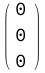
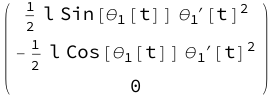
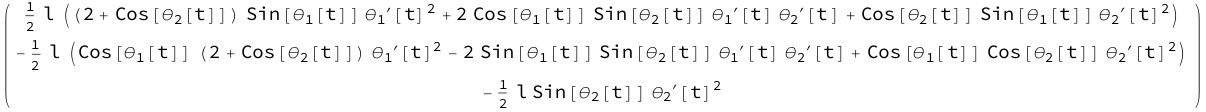
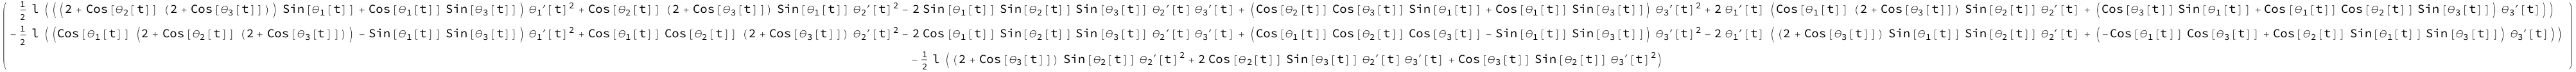
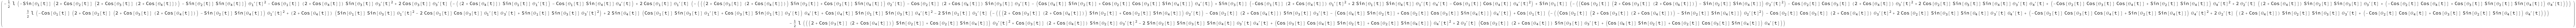
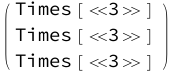
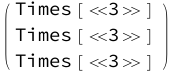
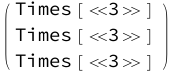

In [240]:
(* differentiate position twice wrt time to get acceleration *)
p[i_] := gs[i][[;; 3, -1]];
v[i_] := D[p[i], t];
a[i_] := D[p[i], {t, 2}];

(* set all joint accelerations to zero since we are assuming constant joint velocity *)
(* a_internal *)
acv[i_] := a[i] /. Thread[D[θs, {t, 2}] -> 0];

acv[1] // Simplify // MatrixForm
acv[2] // Simplify // MatrixForm
acv[3] // Simplify // MatrixForm
acv[4] // Simplify // MatrixForm
acv[5] // Simplify // MatrixForm
acv[6] // Simplify // MatrixForm
acv[7] // Simplify // MatrixForm
acv[8] // Simplify // MatrixForm

0

0

0

0


0

(θ )'[t]
  1
Cos[θ [t]] (θ )'[t]
     1       2

Sin[θ [t]] (θ )'[t]
     1       2

(θ )'[t]
  1
Cos[θ [t]] (θ )'[t] + Sin[θ [t]] Sin[θ [t]] (θ )'[t]
     1       2             1          2       3

Sin[θ [t]] (θ )'[t] - Cos[θ [t]] Sin[θ [t]] (θ )'[t]
     1       2             1          2       3

(θ )'[t] + Cos[θ [t]] (θ )'[t]
  1             2       3
Cos[θ [t]] (θ )'[t] + Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
     1       2             1          2       3
 
>   (Cos[θ [t]] Cos[θ [t]] - Cos[θ [t]] Sin[θ [t]] Sin[θ [t]]) (θ )'[t]
          1          3            2          1          3        4

Sin[θ [t]] (θ )'[t] - Cos[θ [t]] Sin[θ [t]] (θ )'[t] + 
     1       2             1          2       3
 
>   (Cos[θ [t]] Sin[θ [t]] + Cos[θ [t]] Cos[θ [t]] Sin[θ [t]]) (θ )'[t]
          3          1            1          2          3        4

(θ )'[t] + Cos[θ [t]] (θ )'[t] + Sin[θ [t]] Sin[θ [t]] (θ )'[t]
  1             2       3             2          3       4
Cos[θ [t]] (θ )'[t] + Sin[θ [t]] Sin[θ [t]] (θ )'[t] + Cos[θ [t]] Cos[θ [t]] (θ )'[t] - 
     1       2             1          2       3             1          3       4
 
>   Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
         2          1          3       4
 
>   Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
         4          1          2       5
 
>   Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
         2          3          1          4       5
 
>   Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t]
         1          3          4       5

Sin[θ [t]] (θ )'[t] - Cos[θ [t]] Sin[θ [t]] (θ )'[t] + Cos[θ [t]] Sin[θ [t]] (θ )'[t] + 
     1       2             1          2       3             3          1       4
 
>   Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] (θ )'[t] - 
         1          2          3       4
 
>   Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] (θ )'[t] - 
         1          4          2       5
 
>   Cos[θ [t]] Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] (θ )'[t] + 
         1          2          3          4       5
 
>   Sin[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t]
         1          3          4       5

(θ )'[t] + Cos[θ [t]] (θ )'[t] + Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
  1             2       3             2          3       4
 
>   Cos[θ [t]] Cos[θ [t]] (θ )'[t] - Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t]
         2          4       5             3          2          4       5
Cos[θ [t]] (θ )'[t] + Sin[θ [t]] Sin[θ [t]] (θ )'[t] + Cos[θ [t]] Cos[θ [t]] (θ )'[t] - 
     1       2             1          2       3             1          3       4
 
>   Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
         2          1          3       4
 
>   Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
         4          1          2       5
 
>   Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
         2          3          1          4       5
 
>   Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
         1          3          4       5
 
>   Cos[θ [t]] Cos[θ [t]] Cos[θ [t]] (θ )'[t] - 
         1          3          5       6
 
>   Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] - 
         2          5          1          3       6
 
>   Cos[θ [t]] Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] - 
         2          3          4          1          5       6
 
>   Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t] + 
         1          4          3          5       6
 
>   Sin[θ [t]] Sin[θ [t]] Sin[θ [t]] Sin[θ [t]] (θ )'[t]
         1          2          4          5       6

Sin[θ [t]] (θ )'[t] - Cos[θ [t]] Sin[θ [t]] (θ )'[t] + Cos[θ [t]] Sin[θ [t]] (θ )'[t] + 
     1       2             1          2       3             3          1       4
 
>   Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] (θ )'[t] - 
         1          2          3       4
 
>   Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] (θ )'[t] - 
         1          4          2       5
 
>   Cos[θ [t]] Cos[θ [t]] Cos[θ [t]] Sin[θ [t]] (θ )'[t] + 
         1          2          3          4       5
 
>   Sin[θ [t]] 
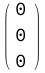
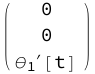
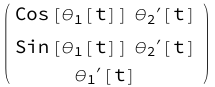
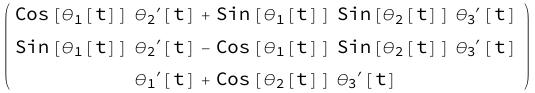
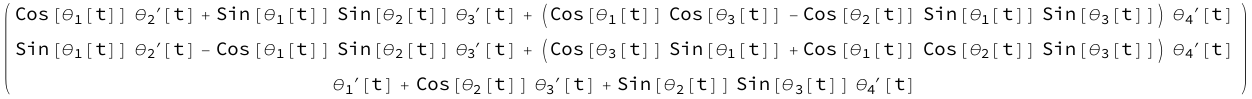
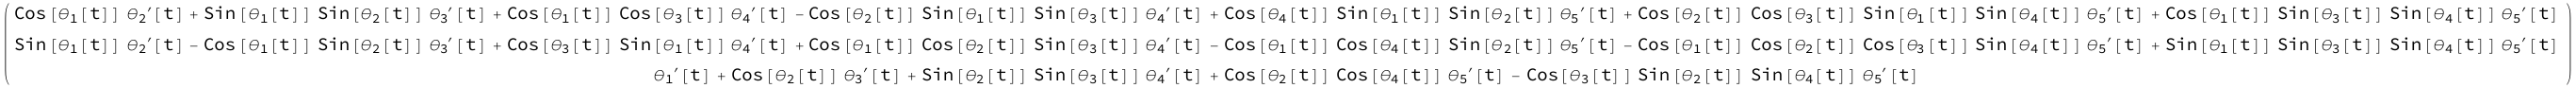
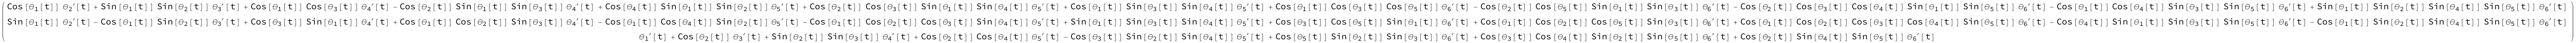
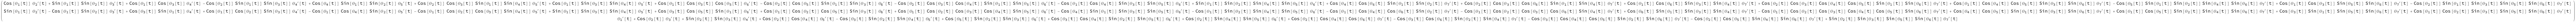

In [266]:
(* differentiate rotation matrix to get angular velocity *)
R[i_] := gs[i][[1 ;; 3, 1 ;; 3]];
ωhat[i_] := D[R[i], t].Transpose[R[i]];

(* ω_internal *)
ω[i_] := UnSkew[ωhat[i]];

(* ωhat[2] // Simplify // MatrixForm *)
ω[1] // Simplify // MatrixForm
ω[2] // Simplify // MatrixForm
ω[3] // Simplify // MatrixForm
ω[4] // Simplify // MatrixForm
ω[5] // Simplify // MatrixForm
ω[6] // Simplify // MatrixForm
ω[7] // Simplify // MatrixForm
ω[8] // Simplify // MatrixForm


In [162]:
(* quaternion to rotation matrix *)
qtoR[{x_, y_, z_, w_}] := {{w^2 + x^2 - y^2 - z^2, 2(x*y - z*w), 2(x*z + y*w)},
                       {2(x*y + z*w), w^2 - x^2 + y^2 - z^2, 2(y*z - x*w)},
                       {2(x*z - y*w), 2(y*z + x*w), w^2 - x^2 - y^2 + z^2}};

$Assumptions = {ak ∈ Vector[3, Reals],
                qk ∈ Vector[4, Reals],
                ωk ∈ Vector[3, Reals],
                Ck ∈ Matrix[{3, 3}, Reals],
                Rk ∈ Matrix[{3, 3}, Reals]};

(* ak = {ax, ay, az};
qk = {qx, qy, qz, qw};
ωk = {ωx, ωy, ωz};
xk = Join[ak, qk, ωk];
Rk = qtoR[qk]; *)

xk = Join[ak, qk, ωk];
(* Ck // TensorDimensions *)

(* rotation matrix from virtual chassis frame to snake head frame *)
(* Ck = {{C11, C12, C13}, {C21, C22, C23}, {C31, C32, C33}}; *)
(* Ck = IdentityMatrix[3]; *)

g = {0, 0, -9.81};

W[i_] := Transpose[Ck].R[i];

(* predicted acceleration measurement at link i *)
αhat[i_] := Transpose[W[i]].Transpose[Rk].(g + ak) + Transpose[Ck].acv[i];

(* predicted angular velocity measurement at link i *)
γhat[i_] := Transpose[W[i]].ωk + Transpose[Ck].ω[i];

(* αhat[2] // TensorReduce // Simplify // MatrixForm
γhat[2] // Simplify; *)


In [120]:

(* zhat = Join[Array[αhat, n], Array[γhat, n]] // Flatten // Simplify; *)

(* measurement jacobian *)
(* h11 = Dt[zhat[[1]], {xk}] // TensorReduce // Simplify *)
(* H = D[zhat, {xk}] // Simplify // MatrixForm; *)

In [178]:
(* Scratch Work *)
(* d = 4;
$Assumptions = {Element[x, Vectors[d, Reals]],
                Element[Q, Matrices[{d, d}, Reals, Symmetric[{1, 2}]]],
                Element[M, Matrices[{d, d}]]};

V = Transpose[x].Q.x // Simplify
D[V, {x}] // Simplify
Transpose[V] // Simplify
Transpose[Q].x + Q.x // TensorReduce // Simplify *)



(* angles = {0, π/2, 0, 0};
gs[3] // Simplify // MatrixForm;
gs[3] /. Thread[θs -> angles] // Simplify // MatrixForm; *)
(* p[3] // Simplify *)
(* v[2] // Simplify *)

(* gs1 = gsi0s[[1]] // MatrixForm
gs2 = TwistExp[ξ[1], θs[[1]]].gsi0s[[2]] // Simplify // MatrixForm
gs3 = TwistExp[ξ[1], θs[[1]]].TwistExp[ξ[2], θs[[2]]].gsi0s[[3]] // Simplify // MatrixForm *)